<a href="https://colab.research.google.com/github/Amine-OMRI/DenseNet-classifier/blob/master/DenseNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip -uq "/content/drive/My Drive/AFF11_resized.zip" -d "/content/Data"

In [0]:
import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.optimizers import SGD
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from imutils import paths   
import numpy as np
import pickle
import random
import os

Using TensorFlow backend.


In [0]:
# definir des nom des repertoires train, et test
TRAIN = "Trunk12_crops_train"
TEST = "Trunk12_crops_test"
# labels des classes
CLASSES = ["alder", "beech","birch","chestnut","ginkgobiloba","hornbeam","horsechestnut","linden","oak","orientalplane","pine","spruce"]

# taille du  batch
BATCH_SIZE = 16

# reprertoire original de la base de données
BASE_PATH = "/content/drive/My Drive/Projet-DL-INFO0907/Trunk12_crops"
#"/content/Data/AFF11_resized"

# repertoire de sauvegarde du modele apres entrainement
miniDenseNet_save_model = 'miniDenseNet.h5' 
MODEL_PATH = F"/content/drive/My Drive/Projet-DL-INFO0907/miniDenseNet_Model/{miniDenseNet_save_model}"

# graphe d'historique d'entrainement
miniDenseNet_Model_trainnig_graphe = 'miniDenseNet_Model_trainnig_graphe.png'
TRAIN_ALL_PLOT_PATH = F"/content/drive/My Drive/Projet-DL-INFO0907/miniDenseNet_Model/{miniDenseNet_Model_trainnig_graphe}"

# repertoire ou sauvegarder le fichier CSV 
BASE_CSV_PATH = "/content/drive/My Drive/Projet-DL-INFO0907/feature_descriptors"

TRAINING_HISTORY_PLOT = 'T.'
TRAINING_HISTORY_PLOT_PATH = F"/content/drive/My Drive/Projet-DL-INFO0907/TRAINING_HISTORY_PLOT/{TRAINING_HISTORY_PLOT}"


In [0]:
# fonction qui dessine les graphes de l'historique d'entrainement
def plot_training(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="test_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

# chemins vers les repertoires train, val et test
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
#trainPath ="/content/Data/AFF11_resized/AFF11_resized_train"
# valPath = os.path.sep.join([config.BASE_PATH, config.VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])
#testPath ="/content/Data/AFF11_resized/AFF11_resized_test"

# nbr total des image dans chacun des repo train test
totalTrain = len(list(paths.list_images(trainPath)))
# totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))



print(testPath)
print(trainPath)

print(totalTest)
print(totalTrain)

/content/drive/My Drive/Projet-DL-INFO0907/Trunk12_crops/Trunk12_crops_test
/content/drive/My Drive/Projet-DL-INFO0907/Trunk12_crops/Trunk12_crops_train
2493
2682


In [0]:
# instancier un objet ImageDataGenerator pour l'augmentation des donnees train
trainAug = ImageDataGenerator(
    #featurewise_std_normalisation = True,
    rescale=1.0/255.0,
    horizontal_flip=True
    )

# instancier un objet ImageDataGenerator pour l'augmentation des donnees test
testAug = ImageDataGenerator(
    #featurewise_std_normalisation = True
    rescale=1.0/255.0
)


# initialiser le generateur de train
train_iterator = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialiser le generateur de test
test_iterator = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)


Found 2682 images belonging to 12 classes.
Found 2493 images belonging to 12 classes.


In [0]:
def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = Dropout(0.2)(trans_x)
    trans_x = MaxPooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters

In [0]:
def dense_net(filters, growth_rate, classes):
    
    #input image RGB 224*224
    input_img = Input(shape=(224, 224, 3))
    
    #convolution 3*3 with 48
    x = Conv2D(48, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)
    
    #dense block 1
    conv_layer_db_1_1 = BatchNormalization()(x)
    conv_layer_db_1_1 = Activation('relu')(conv_layer_db_1_1)
    conv_layer_db_1_1 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_1_1)
    conv_layer_db_1_1 = Dropout(0.2)(conv_layer_db_1_1)
    #concatenate
    block_x_1 = concatenate([conv_layer_db_1_1, x], axis=-1)
    

    
    conv_layer_db_1_2 = BatchNormalization()(block_x_1)
    conv_layer_db_1_2 = Activation('relu')(conv_layer_db_1_2)
    conv_layer_db_1_2 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_1_2)
    conv_layer_db_1_2 = Dropout(0.2)(conv_layer_db_1_2)
    #concatenate
    block_x_2 = concatenate([conv_layer_db_1_2, block_x_1], axis=-1)
    

    conv_layer_db_1_3 = BatchNormalization()(block_x_2)
    conv_layer_db_1_3 = Activation('relu')(conv_layer_db_1_3)
    conv_layer_db_1_3 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_1_3)
    conv_layer_db_1_3 = Dropout(0.2)(conv_layer_db_1_3)
    #concatenate
    block_x_3 = concatenate([conv_layer_db_1_3, block_x_2], axis=-1)
    
    
    conv_layer_db_1_4 = BatchNormalization()(block_x_3)
    conv_layer_db_1_4 = Activation('relu')(conv_layer_db_1_4)
    conv_layer_db_1_4 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_1_4)
    conv_layer_db_1_4 = Dropout(0.2)(conv_layer_db_1_4)
    #concatenate 4 inputs
    block_x_4 = concatenate([conv_layer_db_1_4, conv_layer_db_1_3, conv_layer_db_1_2, conv_layer_db_1_1, x], axis=-1)


    #transition block
    n = int((48 + filters * 4)/2)
   
    dense_x, _ = transition_block(block_x_4, n)

    #dense block 2
    conv_layer_db_2_1 = BatchNormalization()(dense_x)
    conv_layer_db_2_1 = Activation('relu')(conv_layer_db_2_1)
    conv_layer_db_2_1 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_2_1)
    conv_layer_db_2_1 = Dropout(0.2)(conv_layer_db_2_1)
    #concatenate
    block_x_1 = concatenate([conv_layer_db_2_1, dense_x], axis=-1)
   
    
    conv_layer_db_2_2 = BatchNormalization()(block_x_1)
    conv_layer_db_2_2 = Activation('relu')(conv_layer_db_2_2)
    conv_layer_db_2_2 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_2_2)
    conv_layer_db_2_2 = Dropout(0.2)(conv_layer_db_2_2)
    #concatenate
    block_x_2 = concatenate([conv_layer_db_2_2, block_x_1], axis=-1)
    

    conv_layer_db_2_3 = BatchNormalization()(block_x_2)
    conv_layer_db_2_3 = Activation('relu')(conv_layer_db_2_3)
    conv_layer_db_2_3 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_2_3)
    conv_layer_db_2_3 = Dropout(0.2)(conv_layer_db_2_3)
    #concatenate
    block_x_3 = concatenate([conv_layer_db_2_3, block_x_2], axis=-1)
    
    
    conv_layer_db_2_4 = BatchNormalization()(block_x_3)
    conv_layer_db_2_4 = Activation('relu')(conv_layer_db_2_4)
    conv_layer_db_2_4 = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_layer_db_2_4)
    conv_layer_db_2_4 = Dropout(0.2)(conv_layer_db_2_4)
    #concatenate
    block_x_4 = concatenate([conv_layer_db_2_4, conv_layer_db_2_3, conv_layer_db_2_2, conv_layer_db_2_1, dense_x], axis=-1)


    dense_x = BatchNormalization()(block_x_4)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)
    #output
    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


growth_rate = 16
classes = 12
MiniDenseNet = dense_net(growth_rate , growth_rate, classes)
MiniDenseNet.summary()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1296        input_1[0][0]                    
_______________________________________________________________________

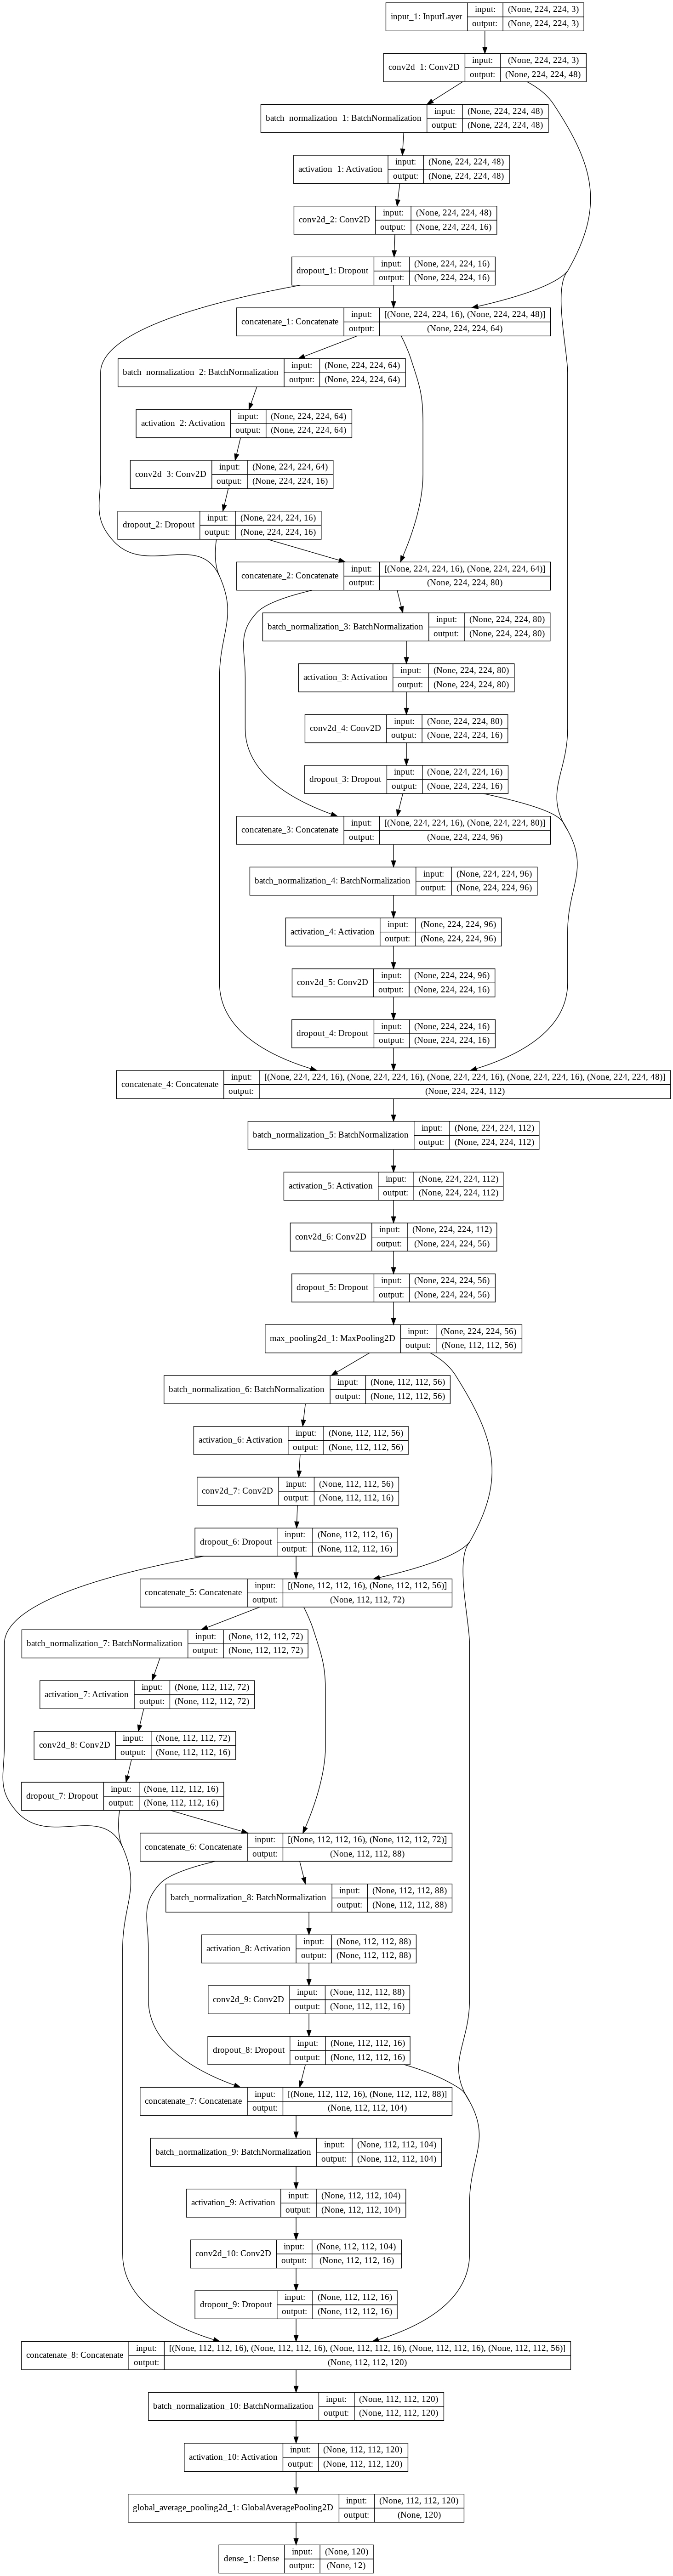

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(MiniDenseNet, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# compiler le nouveau modele
nb_epochs = 150
print("[INFO] compiling model...")

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2/nb_epochs)

MiniDenseNet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training head...")
H = MiniDenseNet.fit_generator(train_iterator, steps_per_epoch=totalTrain // BATCH_SIZE,
                        validation_data=test_iterator,
                        validation_steps=totalTest // BATCH_SIZE,
                        epochs=nb_epochs)

[INFO] compiling model...


[INFO] training head...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/150
167/167 [==============================] - 853s 5s/step - loss: 1.9828 - acc: 0.2954 - val_loss: 2.1191 - val_acc: 0.2593
Epoch 2/150
167/167 [==============================] - 87s 519ms/step - loss: 1.6086 - acc: 0.4442 - val_loss: 2.0640 - val_acc: 0.2725
Epoch 3/150
167/167 [==============================] - 85s 511ms/step - loss: 1.4201 - acc: 0.4954 - val_loss: 2.4143 - val_acc: 0.2717
Epoch 4/150
167/167 [==============================] - 85s 511ms/step - loss: 1.3032 - acc: 0.5312 - val_loss: 11.1088 - val_acc: 0.1429
Epoch 5/150
167/167 [==============================] - 85s 510ms/step - loss: 1.2059 - acc: 0.5600 - val_loss: 1.9406 - val_acc: 0.3476
Epoch 6/150
167/167 [==============================] - 85s 510ms/step - loss: 1.1215 - acc: 0.5950 - val_loss: 2.0307 - val_acc: 0.2725
Epoch 7/150
167/167 [================

KeyboardInterrupt: ignored

[INFO] evaluating after training network head...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         alder       1.00      0.24      0.38        17
         beech       0.91      0.67      0.77        15
         birch       1.00      0.50      0.67        18
      chestnut       0.00      0.00      0.00        16
 ginkgo-biloba       0.11      0.07      0.08        15
      hornbeam       0.75      0.20      0.32        15
horse-chestnut       1.00      0.44      0.61        16
        linden       0.45      0.93      0.61        15
           oak       1.00      0.40      0.57        15
oriental-plane       0.16      1.00      0.28        16
          pine       1.00      0.20      0.33        15
        spruce       1.00      0.64      0.78        22

      accuracy                           0.45       195
     macro avg       0.70      0.44      0.45       195
  weighted avg       0.71      0.45      0.46       195



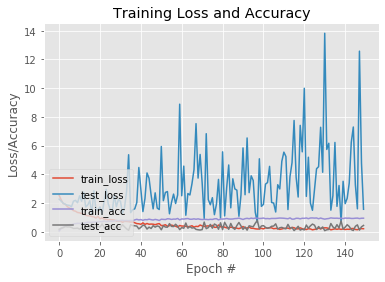

In [0]:
# Evaluer le modele juste apres avoir entrainer 
print("[INFO] evaluating after training network head...")
test_iterator.reset()
predIdxs = MiniDenseNet.predict_generator(test_iterator, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
# afficher les performances de classification
print(classification_report(test_iterator.classes, predIdxs, target_names=test_iterator.class_indices.keys()))
plot_training(H, 150, TRAINING_HISTORY_PLOT_PATH)

train_iterator.reset()
test_iterator.reset()

**Constructing X_train and y_train to use the on the GridSearch**

In [0]:

le = None
classes = 12
# parcourir les repo train et test
# charger les images
print("[INFO] processing TRAIN split...")
imagePaths = list(paths.list_images(trainPath))
# extraire les labels des classes à partir du chemin(nom des dossiers)
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
# creer un objet LabelEncoder
# qui va encoder les label avec des valeur entre 0 and nbr_class-1.
if le is None:
  le = LabelEncoder()
  le.fit(labels)
le.classes_
# parcourir les images 
train_images = []
for i in range(len(imagePaths)):
  print("[INFO] processing image {}/{}".format(i+1 , len(imagePaths)))
  # charger l'image en taille 224x224 pixels
  image = load_img(imagePaths[i], target_size=(224, 224))
  image = img_to_array(image)
  # image => tensor
  # preprocess the image by (1) expanding the dimensions and
  # (2) subtracting the mean RGB pixel intensity from the
  # ImageNet dataset
  image = np.expand_dims(image, axis=0)
  # normalisation
  #image = imagenet_utils.preprocess_input(image)
  train_images.append(image)
x_train = (np.vstack(train_images))
y_train = (le.transform(labels))    
y_train = np_utils.to_categorical(y_train,classes)


[INFO] processing TRAIN split...
[INFO] processing image 1/198
[INFO] processing image 2/198
[INFO] processing image 3/198
[INFO] processing image 4/198
[INFO] processing image 5/198
[INFO] processing image 6/198
[INFO] processing image 7/198
[INFO] processing image 8/198
[INFO] processing image 9/198
[INFO] processing image 10/198
[INFO] processing image 11/198
[INFO] processing image 12/198
[INFO] processing image 13/198
[INFO] processing image 14/198
[INFO] processing image 15/198
[INFO] processing image 16/198
[INFO] processing image 17/198
[INFO] processing image 18/198
[INFO] processing image 19/198
[INFO] processing image 20/198
[INFO] processing image 21/198
[INFO] processing image 22/198
[INFO] processing image 23/198
[INFO] processing image 24/198
[INFO] processing image 25/198
[INFO] processing image 26/198
[INFO] processing image 27/198
[INFO] processing image 28/198
[INFO] processing image 29/198
[INFO] processing image 30/198
[INFO] processing image 31/198
[INFO] processi

In [0]:

print(x_train.shape)
print(y_train.shape)
print(y_train)


**Dégradation programmée du taux d’apprentissage**

In [0]:
#Dégradation standard 
def standard_decay(curr_epoch):
  "standard_decay"
  init_eta = 0.01
  decay = init_eta /100
  eta = init_eta * (1.0/(1.0 + decay * curr_epoch))
  return eta
#Dégradation par pas
def step_decay(curr_epoch):
  "step_decay"
  init_eta = 0.01
  drop_factor = 0.25
  drop_every = 10
  decay = np.floor((1 + curr_epoch) / drop_every)
  eta = init_eta * drop_factor ** decay
  return eta
#Dégradation polynômiale
def poly_decay(curr_epoch):
  "poly_decay"
  total_epochs = 100
  init_eta = 0.01
  order = 1.0
  decay = (1 - (curr_epoch / float(total_epochs))) ** order
  eta = init_eta * decay
  return eta

In [0]:
# learning schedule callback
lrate1 = LearningRateScheduler(step_decay)
lrate2 = LearningRateScheduler(poly_decay)
lrate3 = LearningRateScheduler(standard_decay)
callbacks_list = [[lrate1], [lrate2], [lrate3]]

In [0]:
def define_model():
  growth_rate = 16
  classes = 12
  model = dense_net(growth_rate , growth_rate, classes)
  # compiler le modele
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model

**Evaluation du modèle miniDenseNet**

In [0]:
def GridSearchCV_Evaluation():

    # utiliser le modele avec KerasClassifier
    model = KerasClassifier(build_fn=define_model, verbose=1)
    
    # parametres de la grille de recherche
    grid_param = {'batch_size' : [16, 32],
          'epochs' : [50, 75, 100, 150]}
    
    grid_search = GridSearchCV(estimator=model, param_grid = grid_param)
    grid_result = grid_search.fit(x_train, y_train)

    return grid_result

In [0]:
grid_result = GridSearchCV_Evaluation()
# afficher les resultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# afficher les resultats detailles
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("mean (+/- std) = %f (%f) with: %r" % (mean, stdev, param))

**GridSearchCV on the learning rate**

In [0]:
def GridSearchCV_Evaluation_LR():

    # utiliser le modele avec KerasClassifier
    model = KerasClassifier(build_fn=define_model, epochs = 150,batch_size = 16, verbose=1)
    
    # parametres de la grille de recherche
    grid_param = {'callbacks' : callbacks_list}
    
    grid_search = GridSearchCV(estimator=model, param_grid = grid_param)
    grid_result = grid_search.fit(x_train, y_train)

    return grid_result
grid_result = GridSearchCV_Evaluation_LR()
# afficher les resultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# afficher les resultats detailles
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("mean (+/- std) = %f (%f) with: %r" % (mean, stdev, param))

Epoch 1/150
158/158 [==============================] - 10s 65ms/step - loss: 2.4544 - acc: 0.0886
Epoch 2/150
158/158 [==============================] - 4s 25ms/step - loss: 2.1492 - acc: 0.3354
Epoch 3/150
158/158 [==============================] - 4s 25ms/step - loss: 2.0183 - acc: 0.3354
Epoch 4/150
158/158 [==============================] - 4s 25ms/step - loss: 1.8601 - acc: 0.4810
Epoch 5/150
158/158 [==============================] - 4s 25ms/step - loss: 1.7248 - acc: 0.4684
Epoch 6/150
158/158 [==============================] - 4s 25ms/step - loss: 1.6188 - acc: 0.5063
Epoch 7/150
158/158 [==============================] - 4s 25ms/step - loss: 1.5180 - acc: 0.6013
Epoch 8/150
158/158 [==============================] - 4s 25ms/step - loss: 1.4801 - acc: 0.5886
Epoch 9/150
158/158 [==============================] - 4s 25ms/step - loss: 1.4669 - acc: 0.5759
Epoch 10/150
158/158 [==============================] - 4s 25ms/step - loss: 1.3753 - acc: 0.5886
Epoch 11/150
158/158 [======

RuntimeError: ignored

**Sauvegarder le modèle**

In [0]:
# serialiser le model (sauvegarder sur le disque)
print("[INFO] saving model...")
MiniDenseNet.save(MODEL_PATH)

[INFO] saving model...




**Utiliser le modèle appris comme un extracteur de caractéristiques**

In [0]:
# charger le modèle appris
print("[INFO] loading model...")
#model = load_model(MODEL_PATH)
MiniDenseNet = load_model('/content/drive/My Drive/Projet-DL-INFO0907/miniDenseNet_Model/miniDenseNet.h5')
MiniDenseNet.summary()

[INFO] loading model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 48) 0           batch_normalization_1[0][0]      
____________________________________________________________________

**Utiliser le modèle appris comme un extracteur de caractéristiques**

In [0]:
# initialiser un objet LabelEncoder
le = None
# parcourir les repo train et test
for split in (TRAIN, TEST):
    # charger les images
    print("[INFO] processing '{} split'...".format(split))
    p = os.path.sep.join([BASE_PATH, split])
    imagePaths = list(paths.list_images(p))

    # extraire les labels des classes à partir du chemin
    random.shuffle(imagePaths)
    labels = [p.split(os.path.sep)[-2] for p in imagePaths]
    
    # creer un objet LabelEncoder
    # qui va encoder les label avec des valeur entre 0 and nbr_class-1.
    if le is None:
        le = LabelEncoder()
        le.fit(labels)

    # ouvrir le fichier csv en mode ecriture
    csvPath = os.path.sep.join([BASE_CSV_PATH, "{}.csv".format(split)])
    csv = open(csvPath, "w")
    # parcourir les images en batch
    for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
        print("[INFO] processing batch {}/{}".format(b + 1, int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
        # former des batch avec le chemin des images et leurs labels
        batchPaths = imagePaths[i:i + BATCH_SIZE]
        batchLabels = le.transform(labels[i:i + BATCH_SIZE])
        # initialiser la liste des images qu'on va passer dans le CNN pour l'extraction de caracteristiques
        batchImages = []
        # loop over the images and labels in the current batch
        for imagePath in batchPaths:
            # charger l'image en taille 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            # image => tensor
            image = np.expand_dims(image, axis=0)
            # normalisation
            #image = imagenet_utils.preprocess_input(image)
            # ajouter l'image au batch
            batchImages.append(image)
        # passer l'image le long du CNN, extraire les caractéristiques et les representer comme vecteur
        batchImages = np.vstack(batchImages)
        model_extract = Model(MiniDenseNet.inputs, MiniDenseNet.layers[-2].output)
        features = model_extract.predict(batchImages, batch_size=BATCH_SIZE)
        features = features.reshape((features.shape[0], 120))
        # sauvegarder "label, vecteur de caractéristiques" dans le fichiers CSV
        for (label, vec) in zip(batchLabels, features):
            vec = ",".join([str(v) for v in vec])
            csv.write("{},{}\n".format(label, vec))

    # fermer le fichier CSV
    csv.close()


[INFO] processing 'Trunk12_resized_train split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13
[INFO] processing 'Trunk12_resized_test split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13
